# Word2Vec

In [2]:
import importlib
import nltk

import util
importlib.reload(util)
import matplotlib.pyplot as plt

# IMPORT SOME BASIC TOOLS:
from pprint import pprint
import pyarrow

[nltk_data] Downloading package punkt to /home/vanh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to /home/vanh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to /home/vanh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to /home/vanh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Manipulate Data

In [4]:
#-------------------------------------------------
# Import the rotton tomatoes dataset:
#-------------------------------------------------
from datasets.load import load_dataset
dataset   = load_dataset('rotten_tomatoes')

#-------------------------------------------------
# Flatten out the dataset into a list of sentences and outcome, y
#-------------------------------------------------
sentences = dataset['train']['text']  + dataset['validation']['text'] + dataset['test']['text']    # type: ignore
y         = dataset['train']['label'] + dataset['validation']['label'] + dataset['test']['label']  # type: ignore

#-------------------------------------------------
# Tokenize each of the sentences using nltk:
#-------------------------------------------------
for i,sentence in enumerate(sentences):
    sentences[i] = nltk.word_tokenize(gensim.utils.to_unicode(sentence.lower()))

Using custom data configuration default
Reusing dataset rotten_tomatoes (/home/vanh/.cache/huggingface/datasets/rotten_tomatoes/default/1.0.0/40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46)


  0%|          | 0/3 [00:00<?, ?it/s]

converts the data into a list of lists, with the first level of the list corresponding to the review, and the second level corresponding to the word

In [5]:
print('-------------------------------------------------------')
print('An Example Tokenized Sentence')
print('-------------------------------------------------------')
print(sentences[1])

-------------------------------------------------------
An Example Tokenized Sentence
-------------------------------------------------------
['the', 'gorgeously', 'elaborate', 'continuation', 'of', '``', 'the', 'lord', 'of', 'the', 'rings', '``', 'trilogy', 'is', 'so', 'huge', 'that', 'a', 'column', 'of', 'words', 'can', 'not', 'adequately', 'describe', 'co-writer/director', 'peter', 'jackson', "'s", 'expanded', 'vision', 'of', 'j', '.', 'r', '.', 'r', '.', 'tolkien', "'s", 'middle-earth', '.']


## Training

compute a word-level embedding for the Rotten Tomatoes data using the gensim word2vec implementation.
- trained the word2vec model. Note that word2vec has a several hyper-parameters that will impact the precise nature of the embeddings.
- sg parameter indicates using the skip-gram approach,
- vector_size parameter controls the dimensionality of the embedding 2 -> 2D for each word in vocabulary
- window parameter controls the amount of context we want to use when computing the embedding 2-> use 4 word as context(2from the left side 2 from the right side of the current word)


In [18]:
#-------------------------------------------------
# Import Word2Vec
#-------------------------------------------------
import gensim
from gensim.models import word2vec as w2v

#-------------------------------------------------
# Initialize Word2Vec Model, selecting hyper-paramters
#-------------------------------------------------
model = w2v.Word2Vec(sentences, 
                          sg             = 1,     # Defines the training algorithm. By default (sg=0), CBOW is used. Otherwise (sg=1), skip-gram is employed.
                          min_count      = 2,     # min_count says to ignore all words with total frequency lower than this.
                          vector_size    = 2,     # type: ignore # number of features 
                          window         = 2,     # window is the maximum distance between the current and predicted word within a sentence.
                          sorted_vocab   = 1,     # if 1 (default), sort the vocabulary by descending frequency before assigning word indexes.
                          negative       = 5,     # if > 0, negative sampling will be used, the int for negative specifies how many “noise words” should be drawn (usually between 5-20). # Default is 5. If set to 0, no negative samping is used.
                          max_vocab_size = None   # limit RAM during vocabulary building; if there are more unique words than this, then prune the infrequent ones. # Every 10 million word types need about 1GB of RAM. Set to None for no limit (default).
                         )

In [19]:
#-------------------------------------------------
# Extract the word vectors and vocabulary
#-------------------------------------------------
import numpy as np
vocabulary   = np.array(model.wv.index_to_key)
vectors      = np.array(model.wv.vectors.tolist())

print('-------------------------------------------------------')
print('Dimentions of our word vector matrix')
print('-------------------------------------------------------')
np.shape(vectors)

-------------------------------------------------------
Dimentions of our word vector matrix
-------------------------------------------------------


(10163, 2)

Notice the dimensionality of the word vector matrix: each row corresponds to distinct word in the data, and we have as many columns in the matrix as the size of the embedding (which we specified to be 2 earlier).


Because the vectors are two dimensional, we can easily plot the vectors, and perform some very simple comparisons to see if the embeddings make sense:

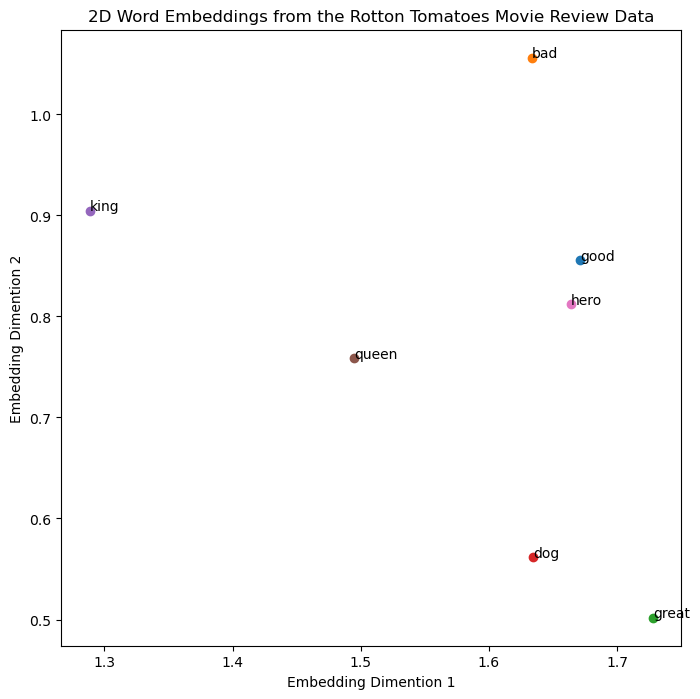

In [20]:
#-------------------------------------------------
# Specify some words we would like to see
#-------------------------------------------------
words = ['good','bad','great','dog','king','queen','hero']

#-------------------------------------------------
# Plot the word vectors
#-------------------------------------------------
plt.figure(figsize = (8,8))
for word in words:
    vector = vectors[np.where(vocabulary == word),:][0][0]  # type: ignore
    plt.scatter(vector[0], vector[1]); plt.annotate(word, (vector[0], vector[1]))

#-------------------------------------------------
# Decorate our plot
#-------------------------------------------------
plt.xlabel('Embedding Dimention 1')
plt.ylabel('Embedding Dimention 2')
plt.title('2D Word Embeddings from the Rotton Tomatoes Movie Review Data')
plt.show()

### Cosine Similarity

At first glance, it seems that the 2-dimensional word embeddings from word2vec provide something sensible: the words that might describe a movie's ranking (good,bad,great) appear to be closer to each-other than words that might describe a potential protagonist (dog,hero,queen,king). We can assess this formally by computing the cosine similarity between the vectors

$\color{orange}{ similarity=\cos(\theta)={\mathbf{A} \cdot \mathbf {B}  \over \|\mathbf {A} \|\|\mathbf {B} \|}={\frac {\sum \limits _{i=1}^{n}{A_{i}B_{i}}}{{\sqrt {\sum \limits _{i=1}^{n}{A_{i}^{2}}}}{\sqrt {\sum \limits _{i=1}^{n}{B_{i}^{2}}}}}}}$

Cosine similarity is generally used as a metric for measuring distance when the magnitude of the vectors does not matter. This happens, for example, when working with text data represented by word counts [Emmery, 2017]. Because methods that do not represent text as word counts may be better assessed using the euclidian distance.

In [21]:
#-------------------------------------------------
# Define the cosine similarity
#-------------------------------------------------
def cosine_similarity(word_a, word_b, vocabulary, vectors):
    vector_a = vectors[np.where(vocabulary == word_a),:][0][0]
    vector_b = vectors[np.where(vocabulary == word_b),:][0][0]
    distance = np.dot(vector_a,vector_b) / (np.linalg.norm(vector_a) * np.linalg.norm(vector_b))
    print('Cosine Similarity between:(', word_a, ',', word_b, ') = ', np.round(distance,3))
    
#-------------------------------------------------
# Compute the cosine similarity
#-------------------------------------------------
cosine_similarity('good', 'bad', vocabulary, vectors)
cosine_similarity('king', 'bad', vocabulary, vectors)
cosine_similarity('king', 'queen', vocabulary, vectors)

Cosine Similarity between:( good , bad ) =  0.995
Cosine Similarity between:( king , bad ) =  0.999
Cosine Similarity between:( king , queen ) =  0.99


### Embedding Variations

Although it's rather impressive that word2vec can represent our tokens in a psudo-sensible way, note that word2vec doesn't have any special intuition about the meanings of these words - it's simply seeking a way to represent them as a function of the contexts they appear in. For this reason, word2vec's representation will be very sensitive to the training data, as well as the settings of the hyper-parameters; this include the initial weights (controlled by your random number generator). Let's see what I mean by re-running word2vec using CBOW instead of skip-grams (i.e. by setting sg = 0:

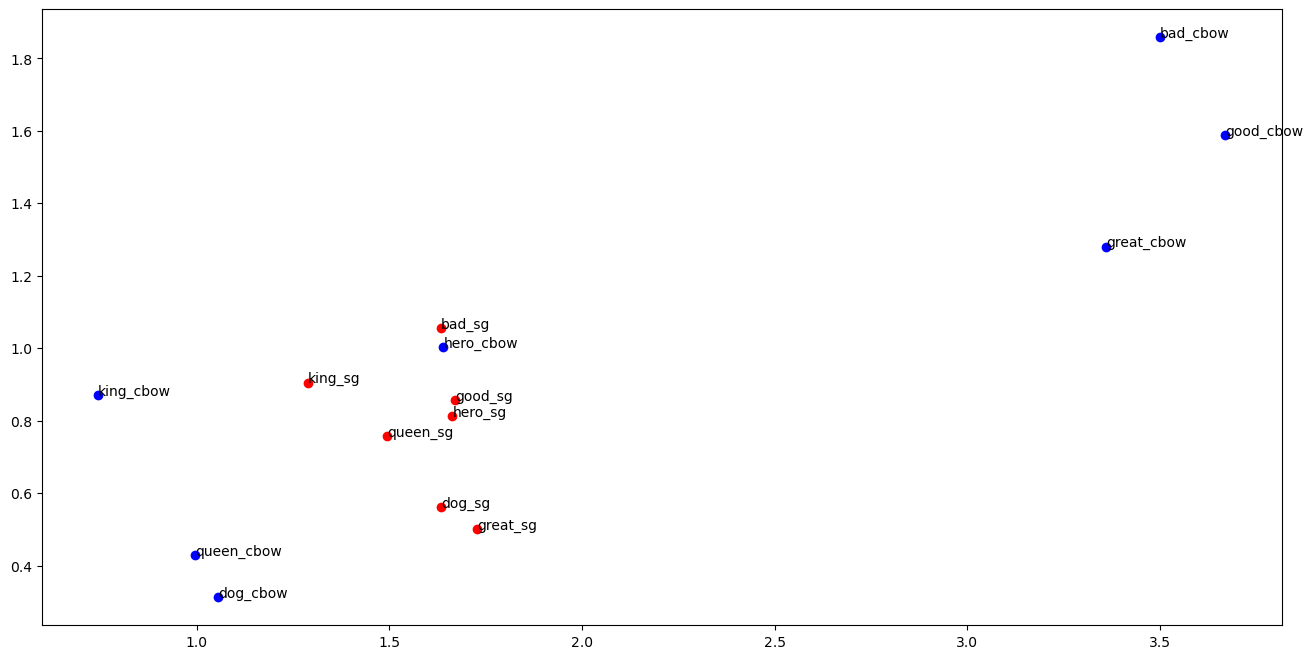

In [28]:
plt.figure(figsize = (16,8))

#-------------------------------------------------
# Specify some words we would like to see
#-------------------------------------------------
words = ['good','bad','great','dog','king','queen','hero']

#-------------------------------------------------
# Plot the word vectors according to model 1
#-------------------------------------------------
vocabulary   = np.array(model.wv.index_to_key)
vectors      = np.array(model.wv.vectors.tolist())
for word in words:
    vector = vectors[np.where(vocabulary == word),:][0][0]  # type: ignore
    plt.scatter(vector[0], vector[1], color='red') 
    plt.annotate(word + '_sg', (vector[0], vector[1]))

    
    
#-------------------------------------------------
# Initialize Word2Vec Model, selecting hyper-paramters
#-------------------------------------------------
model2 = w2v.Word2Vec(sentences, 
                          sg             = 0,     # Defines the training algorithm. By default (sg=0), CBOW is used. Otherwise (sg=1), skip-gram is employed.
                          min_count      = 2,     # min_count says to ignore all words with total frequency lower than this.
                          vector_size    = 2,     # number of features
                          window         = 2,     # window is the maximum distance between the current and predicted word within a sentence.
                          sorted_vocab   = 1,     # if 1 (default), sort the vocabulary by descending frequency before assigning word indexes.
                          negative       = 5,     # if > 0, negative sampling will be used, the int for negative specifies how many “noise words” should be drawn (usually between 5-20). # Default is 5. If set to 0, no negative samping is used.
                          max_vocab_size = None   # limit RAM during vocabulary building; if there are more unique words than this, then prune the infrequent ones. # Every 10 million word types need about 1GB of RAM. Set to None for no limit (default).
                         )

#-------------------------------------------------
# Plot the word vectors according to model 2
#-------------------------------------------------
vocabulary   = np.array(model2.wv.index_to_key)
vectors      = np.array(model2.wv.vectors.tolist())
for word in words:
    vector = vectors[np.where(vocabulary == word),:][0][0]  # type: ignore
    plt.scatter(vector[0], vector[1], color='blue')
    plt.annotate(word + '_cbow', (vector[0], vector[1]))
    

I've colored the points red if they came from the skip-gram embedding, and blue if they came from the CBOW embedding. Notice that the precise embeddings for words have changed, but the relative distances between many of the words seem to be approximately preserved. That is, the distance between good and great in the CBOW implementation is still smaller than the distance between good and king, just as it was in the skip-gram implementation. This reality of word embeddings makes it challenging to perform one-to-one comparisons between the word embeddings generated by two models.


### Embedding Visualizations
Dimensionality reduction via PCA
Obviously, one of the factors that will impact the utility of our word vectors is the size of the embedding dimension. A 10 dimensional representation, for instance, will be better equipped to represent the heterogeneity in the movie-review data than the simple 2 dimensional representation we provided earlier. For this reason, it is common practice to generate embeddings that are a larger, and to then project them into a smaller domains later if/when we want to visualize the data. Let's re-train the embeddings from earlier but this time set size = 100.

In [30]:
#-------------------------------------------------
# Initialize Word2Vec Model, selecting hyper-paramters
#-------------------------------------------------
model = w2v.Word2Vec(sentences, 
                          sg             = 0,     # Defines the training algorithm. By default (sg=0), CBOW is used. Otherwise (sg=1), skip-gram is employed.
                          min_count      = 2,     # min_count says to ignore all words with total frequency lower than this.
                          vector_size    = 100,   # number of features
                          window         = 2,     # window is the maximum distance between the current and predicted word within a sentence.
                          sorted_vocab   = 1,     # if 1 (default), sort the vocabulary by descending frequency before assigning word indexes.
                          negative       = 5,     # if > 0, negative sampling will be used, the int for negative specifies how many “noise words” should be drawn (usually between 5-20). # Default is 5. If set to 0, no negative samping is used.
                          max_vocab_size = None   # limit RAM during vocabulary building; if there are more unique words than this, then prune the infrequent ones. # Every 10 million word types need about 1GB of RAM. Set to None for no limit (default).
                         )

#-------------------------------------------------
# Extract the vocabulary and vectors
#-------------------------------------------------
vocabulary   = np.array(model.wv.index_to_key)
vectors      = np.array(model.wv.vectors.tolist())

reduce the dimensionality if we want to visualize what's happening using PCA transformation of our data 

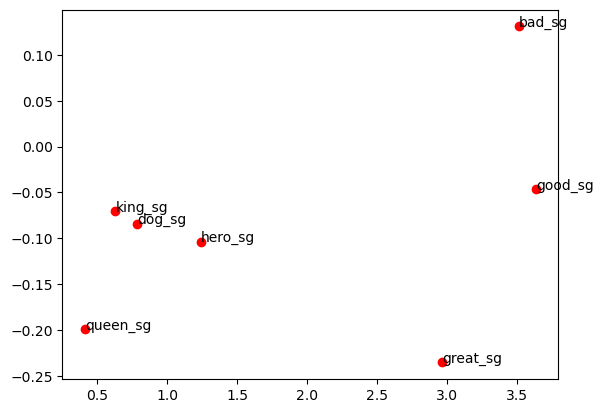

In [31]:
from sklearn.decomposition import PCA

#-------------------------------------------------------------
# Perform PCA on the embeddings
#-------------------------------------------------------------
pca = PCA()
pca.fit(vectors)
vectors_pca = pca.transform(vectors)

#-------------------------------------------------
# Specify some words we would like to see
#-------------------------------------------------
words = ['good','bad','great','dog','king','queen','hero']

#-------------------------------------------------
# Plot the first two principal components
#-------------------------------------------------
vocabulary   = np.array(model.wv.index_to_key)
for word in words:
    vector = vectors_pca[np.where(vocabulary == word),:][0][0]
    plt.scatter(vector[0], vector[1], color='red') 
    plt.annotate(word + '_sg', (vector[0], vector[1]))

Notice that the embedding is similar, albeit not identical, to what we obtained when we set the size of the embedding to 2 directly.

t-SNE
t-distributed stochastic neighbor embedding (t-SNE) is a machine learning algorithm for embedding high-dimensional data, such as word embeddings, in a low-dimensional space. Unlike PCA, it doesn't not make assumptions about orthogonal basis vectors and consequently, provides a more flexible way to embed data within a 2D space. You can learn more about t-SNE from the creator of the method himself [Maaten, 2020]. More specifically, if you are curious about t-SNE, I suggest you read through his software implementation of the algorithm, which is very well commented, and available for download on his website, directly.

Note that, just like word2vec, t-SNE has several hyper-parameters that will impact precisely how it generates the lower-dimensional embedding. You can find the full list of the parameters for the sklearn implementation on-line, along with some general advice on how to select them.

Let's see an example of how to apply t-SNE using the sklearn implementation, and compare it against the embeddings from the first two PCA components.

/home/vanh/anaconda3/envs/sklearn-env/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/vanh/anaconda3/envs/sklearn-env/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Text(0.5, 1.0, 'Word Embeddings using t-SNE')

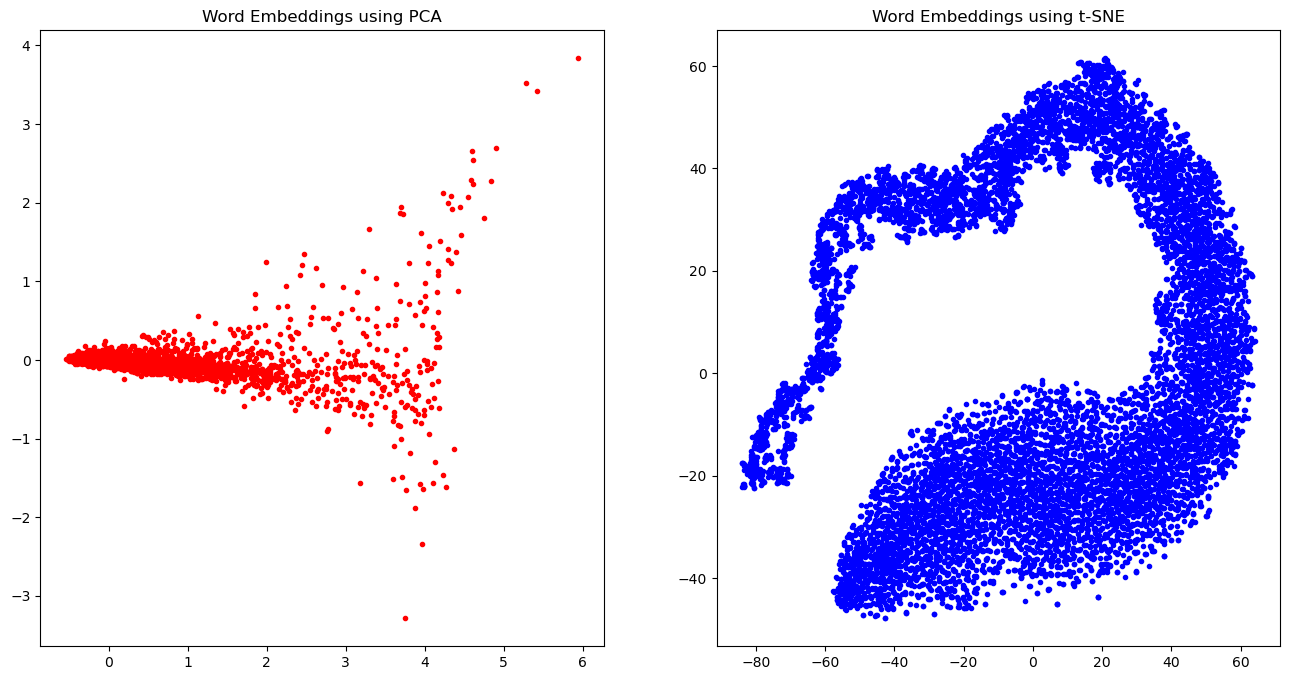

In [32]:
from sklearn.manifold import TSNE  
fig, axs = plt.subplots(1,2, figsize=(16,8))

#--------------------------------------------------------
# Plot embeddings from from PCA (components 1 and 2)
#--------------------------------------------------------
x_vals = [v[0] for v in vectors_pca]
y_vals = [v[1] for v in vectors_pca]
axs[0].plot(x_vals,y_vals,'.', color='red')
axs[0].set_title('Word Embeddings using PCA')

#--------------------------------------------------------            
# Plot dimentionality reduction using t-SNE
#--------------------------------------------------------
tsne         = TSNE(n_components=2, random_state=0)
vectors_tsne = tsne.fit_transform(vectors)

x_vals = [v[0] for v in vectors_tsne]
y_vals = [v[1] for v in vectors_tsne]
axs[1].plot(x_vals,y_vals,'.', color='blue')
axs[1].set_title('Word Embeddings using t-SNE')

### Tensorboard
At the surface, it seems that t-SNE's representation is "clustering" the data more effectively. Albeit, we would need to probe some of these clusters to know if they actually make any sense! Doing this kind of data probing can be a bit challenging in Python directly. There are external applications that make this easier. More specifically, tensorflow has a publically available tool that, as long as you format your data correctly, can be used to perform visualizations of high-dimensional data using some of the techniques we've already discussed (PCA, t-SNE, etc.).

Of course, the tensorboard software requires that we format our vector and vocabulary files appropriately to generate the visualizations. I've provided an example of how to do that below. More specifically, the code below produces two files ending with _tensors.tsv and _metadata.tsv. Those files can be be imported into tensorboard for visualization purposes.

In [1]:
#--------------------------------------------------------
#Save the embeddings for visualization in tensorboard
#--------------------------------------------------------
savename = 'rotton_tomatoes'
with open( savename + '_tensors.tsv', 'w+') as tensors:
    with open( savename + '_metadata.tsv', 'w+') as metadata:
        for word in model.wv.index_to_key:
            encoded = word
            metadata.write(encoded + '\n')
            vector_row = '\t'.join(map(str, model[word]))
            tensors.write(vector_row + '\n')

NameError: name 'model' is not defined

Pre-trained embeddings

pre-trained embedding (glove.6B.zip)

In [36]:
#--------------------------------------------------------
# A function to load the word vectors
#--------------------------------------------------------
def loadGloveModel(File):
    print("Loading Glove Model")
    f = open(File,'r')
    gloveModel = {}
    for line in f:
        splitLines = line.split()
        word = splitLines[0]
        wordEmbedding = np.array([float(value) for value in splitLines[1:]])
        gloveModel[word] = wordEmbedding
    print(len(gloveModel)," words loaded!")
    return gloveModel

#--------------------------------------------------------
# Loading the word vectors
#--------------------------------------------------------
glove_model = loadGloveModel('../data/word_data/glove.6B.100d.txt')

Loading Glove Model
400000  words loaded!


In [37]:
glove_model['fish']

array([-0.65654 ,  0.56149 ,  0.43801 , -0.70816 , -0.02848 , -0.541   ,
        0.32885 ,  0.19502 ,  0.064846, -1.3596  , -0.58534 ,  0.4832  ,
        0.33913 ,  0.35244 ,  0.014004,  0.20392 ,  0.26975 , -0.052985,
       -0.35107 ,  0.78838 ,  0.28599 ,  0.41146 ,  0.71163 , -0.33233 ,
        0.76987 ,  1.2209  , -0.43528 , -0.79026 , -0.30152 ,  0.54479 ,
       -0.6672  ,  0.29536 , -0.12011 , -0.048952,  0.45108 ,  0.14186 ,
       -0.63951 ,  0.14591 ,  0.4785  , -0.8323  , -0.17478 , -1.5759  ,
       -0.8885  , -0.43423 ,  1.0733  ,  0.45304 , -0.51571 , -0.20244 ,
       -0.74595 , -0.36699 ,  0.22531 , -0.16772 , -0.12776 ,  0.7057  ,
       -0.61219 , -0.93637 , -0.10686 , -0.63908 ,  1.1557  ,  0.66294 ,
       -0.42806 ,  0.60697 ,  0.74073 ,  0.28582 ,  1.14    ,  0.18724 ,
       -0.051093, -0.33439 ,  0.72001 , -0.44025 , -0.036515,  0.060187,
        1.0262  ,  0.69332 , -0.26809 ,  0.21283 , -1.3187  , -0.30737 ,
        0.21162 ,  1.0292  ,  0.68704 , -0.25537 , 

Pre-Trained word embeddings
Describe one circumstance where the use of pre-trained word embeddings would not be appropriate for representing words in a given text and explain why.

 Comparing word embedding
Assume that we have a set of embeddings generated from a variety of corpora and we are interested in understanding how similar or different these embeddings are. Propose a method to compare two embeddings generated by word2vec trained on two separate corpora. Implement your method in code and use it to compare the embeddings generated by the Rotten Tomatoes data against the pre-trained glove model embeddings. Note - any method you propose is fine, including methods that may already exist in the literature, insofar as you can explain how your method works, and why you think it's a good approach for comparing the embeddings. It is permissible for you to make simplifications to your method to handle computational complexity.


 Multiple word senses
As we discussed in the lectures, many words can have more than one sense. The word apple, for instance, could refer to a technology company, or to a fruit depending on the context in which it appears. One clear problem of word2vec is that it assumes that the meaning of each word is constant and so, it will not discriminate between these two senses of the word apple when generating the contextual embeddings. Propose a method to address this problem (you do not have to implement the method in code). Note - this can be done through either a formal modification to the word2vec method, or through clever use of pre-processing.